In [1]:
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

# import seaborn as sns; sns.set()

In [2]:
import logging

LOG_LEVEL = "INFO"
LOG_FORMAT = '%(asctime)-15s %(levelname)-9s %(name)s: %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, LOG_LEVEL))

log = logging.getLogger("rbm")

# Restricted Boltzmann Machines (RBMs)

In [624]:
v_0 = X_train[0]
h_0 = rbm.sample_hidden(v_0)

In [625]:
v_1 = v_0 + 1

In [626]:
v = np.repeat(v_0.reshape(1, -1), 3, axis=0)
h = np.repeat(h_0.reshape(1, -1), 3, axis=0)

v[0] = v[0] + 1
v[1] = v[1] + 2

In [627]:
v.shape, h.shape

((3, 784), (3, 500))

In [628]:
np.matmul(v, rbm.c) + np.matmul(h, rbm.b)

array([ 62.28217548, 110.68217548,  13.88217548])

In [629]:
np.matmul(h, rbm.W.T).shape

(3, 784)

In [630]:
x = np.matmul(h, rbm.W.T)
x[0, :].shape

(784,)

In [631]:
np.matmul(h, np.matmul(v, rbm.W).T)

array([[15618.49276408, 27754.98398882,  3482.00153934],
       [15618.49276408, 27754.98398882,  3482.00153934],
       [15618.49276408, 27754.98398882,  3482.00153934]])

In [632]:
np.diag(np.matmul(np.matmul(h, rbm.W.T), v.T))

array([15618.49276408, 27754.98398882,  3482.00153934])

In [633]:
(np.dot(rbm.c, v_0) + np.dot(rbm.b, h_0))

13.88217548324821

In [634]:
np.dot(v_0, np.dot(rbm.W, h_0))

3482.0015393377134

In [635]:
(np.dot(rbm.c, v_1) + np.dot(rbm.b, h_0))

62.282175483248146

In [636]:
np.dot(v_1, np.dot(rbm.W, h_0))

15618.492764077437

In [637]:
(np.matmul(v, rbm.c) +
 np.matmul(h, rbm.b) +
 np.diag(np.matmul(np.matmul(h, rbm.W.T), v.T)))

array([15680.77493956, 27865.6661643 ,  3495.88371482])

In [638]:
rbm2 = BernoulliRBM(784, 500)

In [639]:
rbm.b.shape, np.matmul(v, rbm2.W)

((500,), array([[-0.07390445,  0.1851988 ,  0.21088851, ..., -0.52837337,
         -0.31224092, -0.25181992],
        [-0.12336721,  0.4392113 ,  0.45968023, ..., -1.01763103,
         -0.57146313, -0.38603714],
        [-0.02444169, -0.0688137 , -0.03790321, ..., -0.0391157 ,
         -0.05301871, -0.11760271]]))

In [640]:
rbm2.proba_hidden(v).shape == h.shape

True

In [641]:
rbm2.proba_visible(h).shape == v.shape

True

In [642]:
rbm2.sample_hidden(v).shape == h.shape

True

In [643]:
rbm2.sample_visible(h).shape == v.shape

True

In [644]:
v__0, v_k = rbm2.contrastive_divergence(v, k=4)
dc, db, dw = rbm2.grad(v__0, v_k)

In [645]:
dc.shape, db.shape, dw.shape

((3, 784), (3, 500), (3, 784, 500))

In [646]:
rbm2.step(v)

In [647]:
X_train[:5].shape

(5, 784)

In [648]:
[rbm.free_energy(x) for x in X_train[:5]]

[-3497.8698855415087,
 -3554.8279414622416,
 -1972.6676152783457,
 -4895.682283326255,
 -4157.402378020097]

In [649]:
rbm2.free_energy(X_train[:5])

array([-3581.58333453, -3481.22774408, -1850.58206704, -4521.88954068,
       -4045.65008955])

In [650]:
rbm.c = rbm2.c
rbm.b = rbm2.b
rbm.W = rbm2.W

In [651]:
for i in range(len(X_train[:5])):
    a = [rbm.proba_hidden(x) for x in X_train[:5]][i]
    b = rbm2.proba_hidden(X_train[:5])[i]
    eps = 0.000001

    assert np.all((b + eps > a) & (b - eps < a))

In [652]:
# gradients
v = X_train[:5]
v_k = rbm2.sample_visible(rbm2.sample_hidden(X_train[:5]))

a = rbm2.grad(v, v_k)
b = [rbm.grad(v[i], v_k[i]) for i in range(len(v))]

In [653]:
b = [np.array(x) for x in list(zip(*b))]

In [654]:
eps = 0.00001

In [655]:
[np.all(np.all((b[i] + eps > a[i]) & (b[i] - eps < a[i]))) for i in range(len(a))]

[True, True, True]

In [656]:
rbm2.free_energy(X_train[:5])

array([-3581.58333453, -3481.22774408, -1850.58206704, -4521.88954068,
       -4045.65008955])

In [657]:
np.array([rbm.free_energy(x) for x in X_train[:5]])

array([-3581.58333453, -3481.22774408, -1850.58206704, -4521.88954068,
       -4045.65008955])

In [658]:
visible = np.matmul(v, rbm2.c)
hidden = rbm2.b + np.matmul(v, rbm2.W)
- (visible + np.sum(np.log(1 + np.exp(hidden)), axis=1))

array([-3581.58333453, -3481.22774408, -1850.58206704, -4521.88954068,
       -4045.65008955])

In [691]:
    class BatchBernoulliRBM(object):
        """
        RBM with Bernoulli variables for hidden and visible states.
        """
        def __init__(self, num_visible, num_hidden):
            super(BatchBernoulliRBM, self).__init__()
            self.num_visible = num_visible
            self.num_hidden = num_hidden

            self.c, self.b, self.W = self.initialize(self.num_visible, self.num_hidden)

        @staticmethod
        def initialize(num_visible, num_hidden):
            # biases for visible and hidden, respectively
            c = np.zeros(num_visible)
            b = np.zeros(num_hidden)

            # weight matrix
            W = np.random.normal(0.0, 0.01, (num_visible, num_hidden))

            return c, b, W

        def energy(self, v, h):
            return - (np.matmul(v, self.c) +
                      np.matmul(h, self.b) +
                      np.matmul(h, np.matmul(v, rbm.W).T))

        def proba_visible(self, h):
            "Computes p(v | h)."
            return sigmoid(self.c + np.matmul(h, self.W.T))

        def proba_hidden(self, v):
            "Computes p(h | h)."
            return sigmoid(self.b + np.matmul(v, self.W))

        def sample_visible(self, h):
            "Samples visible units from the given hidden units `h`."
            # compute p(V_j = 1 | h)
            probas = self.proba_visible(h)
            # equiv. of V_j ~ p(V_j | h)
            rands = np.random.random(size=probas.shape)
            v = (probas > rands).astype(int)
            return v

        def sample_hidden(self, v):
            "Samples hidden units from the given visible units `v`."
            # compute p(H_{\mu} = 1 | v)
            probas = self.proba_hidden(v)
            # euqiv. of H_{\mu} ~ p(H_{\mu} | h)
            rands = np.random.random(size=probas.shape)
            h = (probas > rands).astype(np.int)
            return h

        def free_energy(self, v):
            # unnormalized
            # F(v) = - log \tilde{p}(v) = - \log \sum_{h} \exp ( - E(v, h))
            # using Eq. 2.20 (Fischer, 2015) for \tilde{p}(v)
            if len(v.shape) < 2:
                v = v.reshape(1, -1)
            visible = np.matmul(v, self.c)
            hidden = self.b + np.matmul(v, self.W)
            return - (visible + np.sum(np.log(1 + np.exp(hidden)), axis=1))

        def contrastive_divergence(self, v_0, k=1):
            v = v_0
            for t in range(k):
                h = self.sample_hidden(v)
                v = self.sample_visible(h)

            return v_0, v

        def grad(self, v_0, v_k):
            "Estimates the gradient of the negative log-likelihood using CD-k."
            proba_h_0 = self.proba_hidden(v_0)
            proba_h_k = self.proba_hidden(v_k)

            delta_c = v_0 - v_k
            delta_b = proba_h_0 - proba_h_k

            x = proba_h_0.reshape(proba_h_0.shape[0], 1, proba_h_0.shape[1])
            y = v_0.reshape(v_0.shape[0], v_0.shape[1], 1)
            z_0 = np.matmul(y, x)

            x = proba_h_k.reshape(proba_h_k.shape[0], 1, proba_h_k.shape[1])
            y = v_k.reshape(v_k.shape[0], v_k.shape[1], 1)
            z_k = np.matmul(y, x)
            delta_W = z_0 - z_k

            return delta_c, delta_b, delta_W

        def step(self, vs, k=1, lr=0.1, lmda=0.0):
            "Performs a single gradient ascent step using CD-k on the batch `vs`."
            v_0, v_k = self.contrastive_divergence(v, k=k)

            # compute gradient for each observed visible configuration
            dc, db, dW = self.grad(v_0, v_k)

            # accumulate gradients
            delta_c = np.mean(dc, axis=0)
            delta_b = np.mean(db, axis=0)
            delta_W = np.mean(dW, axis=0)

            # update parameters
            self.c += lr * delta_c
            self.b += lr * delta_b
            self.W += lr * delta_W

            # possible apply weight-decay
            if lmda > 0.0:
                self.c -= lmda * self.c
                self.b -= lmda * self.b
                self.W -= lmda * self.W

        def fit(self, train_data, k=1, learning_rate=0.01, num_epochs=5, batch_size=64, test_data=None):
            num_samples = train_data.shape[0]
            indices = np.arange(num_samples)
            np.random.shuffle(indices)

            loglikelihood_train = []
            loglikelihood = []

            for epoch in range(1, num_epochs + 1):
                # compute train & test negative log-likelihood
                nll_train = np.mean(rbm.free_energy(train_data))
                # nll_train = np.mean(np.array([rbm.free_energy(v) for v in train_data]))
                loglikelihood_train.append(nll_train)
                log.info(f"[{epoch} / {NUM_EPOCHS}] NLL (train): {nll_train:>20.5f}")

                if test_data is not None:
                    nll = np.mean(np.array([rbm.free_energy(v) for v in test_data]))
                    log.info(f"[{epoch} / {NUM_EPOCHS}] NLL (test):  {nll:>20.5f}")
                    loglikelihood.append(nll)

                # iterate through dataset in batches
                bar = tqdm(total=num_samples)
                for start in range(0, num_samples, batch_size):
                    # ensure we don't go out-of-bounds
                    end = min(start + batch_size, num_samples)

                    # take a gradient-step
                    rbm.step(train_data[start: end], k=k, lr=learning_rate)

                    # update progress
                    bar.update(end - start)

                bar.close()

                # shuffle indices for next epoch
                np.random.shuffle(indices)

            # compute train & test negative log-likelihood of final batch
            nll_train = np.mean([rbm.free_energy(v) for v in train_data])
            loglikelihood_train.append(nll_train)
            log.info(f"[{epoch} / {NUM_EPOCHS}] NLL (train): {nll_train:>20.5f}")

            if test_data is not None:
                nll = np.mean([rbm.free_energy(v) for v in test_data])
                log.info(f"[{epoch} / {NUM_EPOCHS}] NLL (test):  {nll:>20.5f}")
                loglikelihood.append(nll)

            return loglikelihood_train, loglikelihood

        def loss(self, samples_true, per_sample_hidden=100):
            """
            Computes the difference in empirical distributions observed in `samples_true` and samples
            of visible units obtained from the model, using the same initial state.

            Parameters
            ----------
            samples_true: array-like
                True samples of visible units to compare to.
            per_sample_hidden: int
                Number of `h` to "partially marginalize" over when computing p(v) = p(v | h) p(h).

            Returns
            -------
            loss: float
                Difference between the two distributions.

            Notes
            -----
            Can be very inaccurate estimate of how well the model is performing since one is NOT completely
            marginalizing out all hidden variables.

            """
            k = per_sample_hidden
            # the loss is the log energy-difference between the p(v) and p(v_k), where `v_k` is the Gibbs sampled visible unit
            return np.mean([
                self.free_energy(v) - self.free_energy(self.contrastive_divergence(v, k)[1])
                for v in samples_true
            ])

        def reconstruct(self, v, num_samples=100):
            samples = self.sample_visible(self.sample_hidden(v))
            for _ in range(num_samples - 1):
                samples += self.sample_visible(self.sample_hidden(v))

            probs = samples / num_samples 

            return probs


In [692]:
def sigmoid(z):
    # clip the values due to possibility of overflow
    return 1.0 / (1.0 + np.exp(-np.maximum(np.minimum(z, 30), -30)))


### Restricted Boltzmann Machine ###
class BernoulliRBM(object):
    """
    RBM with Bernoulli variables for hidden and visible states.
    """
    def __init__(self, num_visible, num_hidden):
        super(BernoulliRBM, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        self.c, self.b, self.W = self.initialize(self.num_visible, self.num_hidden)
      
    @staticmethod
    def initialize(num_visible, num_hidden):
        # biases for visible and hidden, respectively
        c = np.zeros(num_visible)
        b = np.zeros(num_hidden)

        # weight matrix
        # Results on MNIST are highly dependent on this initialization
        W = np.random.normal(0.0, 0.01, (num_visible, num_hidden))
        
        return c, b, W

    def energy(self, v, h):
        return - (np.dot(self.c, v) + np.dot(self.b, h) + np.dot(v, np.dot(self.W, h)))

    def proba_visible(self, h):
        "Computes p(v | h)."
        return sigmoid(self.c + np.dot(self.W, h))

    def proba_hidden(self, v):
        "Computes p(h | h)."
        return sigmoid(self.b + np.dot(self.W.T, v))

    def sample_visible(self, h):
        "Samples visible units from the given hidden units `h`."
        # compute p(V_j = 1 | h)
        probas = self.proba_visible(h)
        # equiv. of V_j ~ p(V_j | h)
        rands = np.random.random(size=probas.shape)
        v = (probas > rands).astype(int)
        return v

    def sample_hidden(self, v):
        "Samples hidden units from the given visible units `v`."
        # compute p(H_{\mu} = 1 | v)
        probas = self.proba_hidden(v)
        # euqiv. of H_{\mu} ~ p(H_{\mu} | h)
        rands = np.random.random(size=probas.shape)
        h = (probas > rands).astype(np.int)
        return h

    def free_energy(self, v):
        # unnormalized
        # F(v) = - log \tilde{p}(v) = - \log \sum_{h} \exp ( - E(v, h))
        # using Eq. 2.20 (Fischer, 2015) for \tilde{p}(v)
        visible = np.dot(self.c, v)
        hidden = self.b + np.dot(self.W.T, v)
        return - (visible + np.sum(np.log(1 + np.exp(hidden))))
    
    def contrastive_divergence(self, v_0, k=1):
        h = self.sample_hidden(v_0)
        v = self.sample_visible(h)
        
        if k > 1:
            for t in range(k):
                h = self.sample_hidden(v)
                v = self.sample_visible(h)
                
        return v_0, v

    def grad(self, v_0, v_k):
        "Estimates the gradient of the negative log-likelihood using CD-k."
        proba_h_0 = self.proba_hidden(v_0)
        proba_h_k = self.proba_hidden(v_k)
        
        delta_c = v_0 - v_k
        delta_b = proba_h_0 - proba_h_k

        # reshape so that we can compute v_j h_{\mu} by
        # taking the dot product to obtain `delta_W`
        v_0 = np.reshape(v_0, (-1, 1))
        proba_h_0 = np.reshape(proba_h_0, (1, -1))
        
        v_k = np.reshape(v_k, (-1, 1))
        proba_h_k = np.reshape(proba_h_k, (1, -1))
        
        delta_W = np.dot(v_0, proba_h_0) - np.dot(v_k, proba_h_k)
        
        return delta_c, delta_b, delta_W
    
    def step(self, vs, k=1, lr=0.1, lmda=0.0):
        "Performs a single gradient ascent step using CD-k on the batch `vs`."
        # TODO: can we perform this over the batch using matrix multiplication instead?
        v_0, v_k = self.contrastive_divergence(vs[0], k=k)
        delta_c, delta_b, delta_W = self.grad(v_0, v_k)
        for v in vs[1:]:
            # perform CD-k
            v_0, v_k = self.contrastive_divergence(v, k=k)
            # compute gradient for each observed visible configuration
            dc, db, dW = self.grad(v_0, v_k)
            # accumulate gradients
            delta_c += dc
            delta_b += db
            delta_W += dW

        # update parameters
        self.c += lr * (delta_c / len(vs))
        self.b += lr * (delta_b / len(vs))
        self.W += lr * (delta_W / len(vs))

        # possible apply weight-decay
        if lmda > 0.0:
            self.c -= lmda * self.c
            self.b -= lmda * self.b
            self.W -= lmda * self.W
        
    def loss(self, samples_true, per_sample_hidden=100):
        """
        Computes the difference in free energy, i.e.
        
            log p(v_k) - log p(v_0)
            
        where `v_0` is sample from data, and `v_k` is the sample from the chain initialized at v_0.

        Parameters
        ----------
        samples_true: array-like
            True samples of visible units to compare to.
        per_sample_hidden: int
            Number of `h` to "partially marginalize" over when computing p(v) = p(v | h) p(h).

        Returns
        -------
        loss: float
            Difference between the two distributions.
            
        Notes
        -----
        Could also consider the reconstruction error, i.e. how much the mean-squared error between the
        observed v_0 and the generated v_k

        """
        # the loss is the log energy-difference between the p(v) and p(v_k), where `v_k` is the Gibbs sampled visible unit
        return np.mean([
            self.free_energy(v) - self.free_energy(self.contrastive_divergence(v, per_sample_hidden)[1])
            for v in samples_true
        ])

    def reconstruct(self, v, num_samples=100):
        samples = self.sample_visible(self.sample_hidden(v))
        for _ in range(num_samples - 1):
            samples += self.sample_visible(self.sample_hidden(v))

        probs = samples / num_samples 

        return probs


### Quickly making sure everything works

In [693]:
# testah
num_visible = 100
num_hidden = 50
rbm = BernoulliRBM(num_visible, num_hidden)
# v = np.random.randint(2, size=num_visible)
v = np.random.randint(2, size=num_visible)
h = np.random.randint(2, size=num_hidden)
rbm.energy(v, h)

0.075761461352016

In [694]:
rbm.W.shape

(100, 50)

In [695]:
rbm.b.shape

(50,)

In [696]:
h = rbm.sample_hidden(v)
v = rbm.sample_visible(h)
print(v)

[1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1
 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0]


In [697]:
v_0, v_k = rbm.contrastive_divergence(v, k=10)
v_0, v_k

(array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0]),
 array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]))

In [698]:
dc, db, dW = rbm.grad(v_0, v_k)

In [699]:
dc.shape, db.shape, dW.shape

((100,), (50,), (100, 50))

In [700]:
rbm.W.max(), rbm.c.max(), rbm.b.max()

(0.03176074688354214, 0.0, 0.0)

# MNIST

## Load data

In [701]:
import os
from six.moves import urllib
from sklearn.datasets import fetch_mldata

# Alternative method to load MNIST, since mldata.org is often down...
from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"

if os.path.exists(mnist_path):
    log.info(f"Found existing file at {mnist_path}; loading...")
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
else:
    log.info(f"Dataset not found at {mnist_path}; downloading...")
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    log.info("Success!")

2018-06-29 22:57:45,767 INFO      rbm: Found existing file at ./mnist-original.mat; loading...


## Split into training and test

In [711]:
# train-test split
from sklearn.model_selection import train_test_split

# in case we want to use `cupy` to run on the GPU
X = np.asarray(mnist["data"])
y = np.asarray(mnist["target"])

X_train, X_test, y_train, y_test = train_test_split(X, y)

# clip values since we're working with binary variables and original images have domain [0, 255]
X_train = X_train.clip(0, 1)
X_test = X_test.clip(0, 1)

## Train

In [712]:
from tqdm import tqdm

In [719]:
# model parameters
USE_GPU = False

if USE_GPU:
    import cupy as np
else:
    import numpy as np

NUM_HIDDEN = 500

# model
rbm = BernoulliRBM(X_train.shape[1], NUM_HIDDEN)

In [720]:
rbm.W.shape, rbm.c.shape, rbm.b.shape

((784, 500), (784,), (500,))

In [721]:
# training parameters
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.1
K = 1

# train
log.info(f"Starting training")
num_samples = X_train.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)

loglikelihood = []
loglikelihood_train = []

for epoch in range(1, NUM_EPOCHS + 1):
    # compute train & test negative log-likelihood
    nll_train = np.mean([rbm.free_energy(v) for v in X_train])
    loglikelihood_train.append(nll_train)
    log.info(f"[{epoch} / {NUM_EPOCHS}] NLL (train): {nll_train:>20.5f}")
    
    nll = np.mean([rbm.free_energy(v) for v in X_test])
    log.info(f"[{epoch} / {NUM_EPOCHS}] NLL (test):  {nll:>20.5f}")
    loglikelihood.append(nll)

    # iterate through dataset in batches
    bar = tqdm(total=num_samples)
    for start in range(0, num_samples, BATCH_SIZE):
        # ensure we don't go out-of-bounds
        end = min(start + BATCH_SIZE, num_samples)
        
        # take a gradient-step
        rbm.step(X_train[start: end], k=K, lr=LEARNING_RATE)
        
        # update progress
        bar.update(end - start)
        
    bar.close()

    # shuffle indices for next epoch
    np.random.shuffle(indices)

2018-06-29 23:01:23,969 INFO      rbm: Starting training
2018-06-29 23:01:32,174 INFO      rbm: [1 / 100] NLL (train):           -347.31363
2018-06-29 23:01:34,857 INFO      rbm: [1 / 100] NLL (test):            -347.32702

  8%|▊         | 4416/52500 [00:15<02:56, 272.94it/s]

KeyboardInterrupt: 

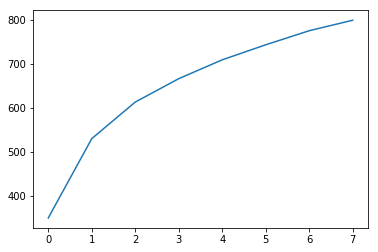

In [143]:
plt.plot(- np.array(loglikelihood))

## Display reconstructions of test-samples

In [144]:
def flip(x, p):
    x = x.copy()
    mask = np.random.random(size=x.shape) < p
    flipped = (~(x.astype(np.bool))).astype(np.int)
    x[mask] = flipped[mask]
    return x

2018-06-29 21:29:14,316 INFO      rbm: Reconstruction error of (0, 0): 0.08011479591836734 (noise: 0.1)
2018-06-29 21:29:14,883 INFO      rbm: Reconstruction error of (0, 2): 0.09171683673469389 (noise: 0.1)
2018-06-29 21:29:15,248 INFO      rbm: Reconstruction error of (0, 4): 0.08248086734693877 (noise: 0.1)
2018-06-29 21:29:15,625 INFO      rbm: Reconstruction error of (0, 6): 0.08184311224489794 (noise: 0.1)
2018-06-29 21:29:15,994 INFO      rbm: Reconstruction error of (1, 0): 0.04879591836734694 (noise: 0.1)
2018-06-29 21:29:16,312 INFO      rbm: Reconstruction error of (1, 2): 0.07076785714285715 (noise: 0.1)
2018-06-29 21:29:16,646 INFO      rbm: Reconstruction error of (1, 4): 0.07475510204081633 (noise: 0.1)
2018-06-29 21:29:17,235 INFO      rbm: Reconstruction error of (1, 6): 0.08326020408163265 (noise: 0.1)
2018-06-29 21:29:17,581 INFO      rbm: Reconstruction error of (2, 0): 0.09208673469387754 (noise: 0.1)
2018-06-29 21:29:18,103 INFO      rbm: Reconstruction error of (

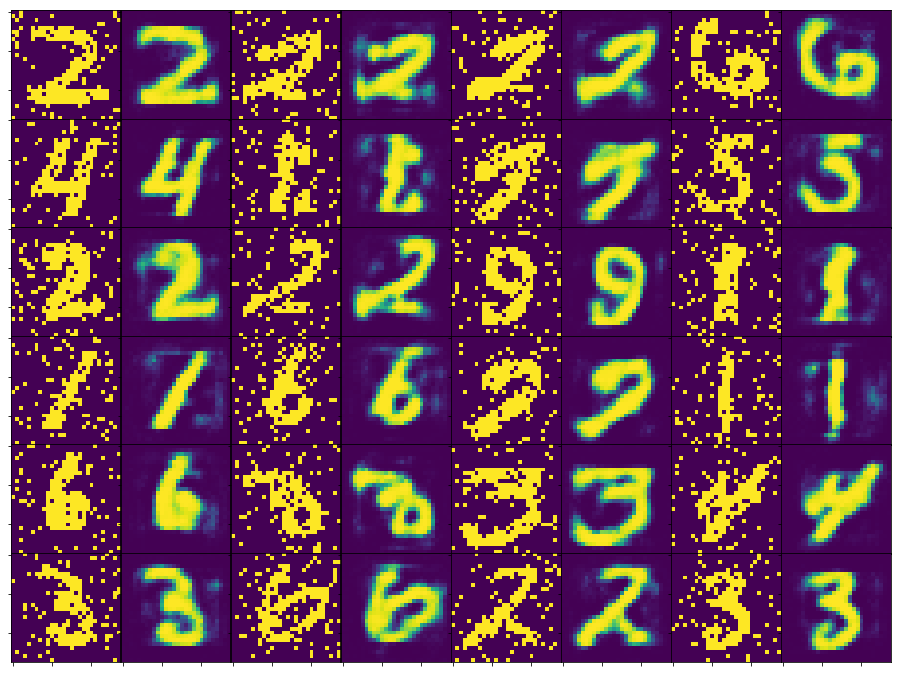

 52%|█████▏    | 27072/52500 [01:50<01:40, 253.24it/s]

In [145]:
# display a couple of testing examples
import matplotlib.pyplot as plt

# plot some reconstructions
from matplotlib import gridspec

n_rows = 6
n_cols = 8

fig, axes = plt.subplots(n_rows, n_cols, 
                         sharex=True, sharey=True, 
                         figsize=(16, 12),
                         # make it tight
                         gridspec_kw=dict(wspace=-0.1, hspace=-0.01))

for i in range(n_rows):
    for j in range(n_cols // 2):
        v_0 = X_test[np.random.randint(X_test.shape[0])]
        
        # introduce noise
        noise = 0.1
        v = flip(v_0, noise)
        
        probs = rbm.reconstruct(v, num_samples=1000)
#         num_samples = 100
#         k = 100
#         _, probs = rbm.contrastive_divergence(v, k=k)

#         for _ in range(num_samples - 1):
#             probs += rbm.contrastive_divergence(v, k=k)[1]
        
#         probs = probs / num_samples

        # in case we've substituted with `cupy`
        if np.__name__ != "numpy":
            v = np.asnumpy(v)
            probs = np.asnumpy(probs)
            
        log.info(f"Reconstruction error of {(i, 2 * j)}: {np.mean(np.abs(v_0 - probs))} (noise: {noise})")

        axes[i][2 * j].imshow(np.reshape(v, (28, 28)))
        axes[i][2 * j + 1].imshow(np.reshape(probs, (28, 28)))

        # customization; remove labels
        axes[i][2 * j].set_xticklabels([])
        axes[i][2 * j].set_yticklabels([])

        axes[i][2 * j + 1].set_xticklabels([])
        axes[i][2 * j + 1].set_yticklabels([])

# Ising Model

In [89]:
def create_updown_couplings(N, coupling_values=[0, 1]):
    "Returns an of dim N x N x N x N, representing 2D neighbor-couplings for each entry."
    J = np.zeros((N, N, N, N))
    
    for i in range(N):
        for j in range(N):
            if i + 1 < N:
                J[i, j, i + 1, j] = np.random.choice(coupling_values)
            if i - 1 > 0:
                J[i, j, i - 1, j] = np.random.choice(coupling_values)
            if j + 1 < N:
                J[i, j, i, j + 1] = np.random.choice(coupling_values)
            if j - 1 > 0:
                J[i, j, i, j - 1] = np.random.choice(coupling_values)
    return J

In [90]:
import itertools as it

In [91]:
import numpy as np


class Ising(object):
    """
    Ising model.
    """
#     boltzmann_constant = 1.38064852e-23
    
    def __init__(self, T, N, field=None, couplings=None, domain=[0, 1]):
        super(Ising, self).__init__()
        self.domain = domain
        self.N = N
#         self.beta = 1.0 / (self.boltzmann_constant * T)
        self.beta = 1.0 / T
        self.T = T
        
        self.h = field if field is not None else np.random.randn(N, N)
        self.J = couplings if couplings is not None else create_updown_couplings(N, self.domain)

    def energy(self, x):
        # (J[s] * x) gives us J_{s, i} * x_i for all i, and then we multiply by 
        couplings_energy = np.sum([
            np.sum(self.J[i, j] * x * x[i, j])
            for i in range(self.N)
            for j in range(self.N)])
        field_energy = np.sum(self.h * x)
        return - (field_energy + 0.5 * couplings_energy)
    

    def sample(self, state, full=True):
        """
        Parameters
        ----------
        n: int
            Number of timesteps to sample for

        """
        if full:
            indices = it.product(range(N), range(N))
        else:
            indices = [np.random.randint(self.N, size=2)]
        
        for (i, j) in indices:
            delta_E = np.sum(self.J[i, j] * state)
    #         delta_E = 2 * (delta_E + self.h[i, j])
            delta_E = (delta_E + self.h[i, j])

            u = np.random.uniform()
            new_state = state.copy()

            if delta_E > 0:
                if np.exp(- self.beta * delta_E) > u:
                    # accept flip
                    new_state[i, j] = self.domain[-1] if state[i, j] < self.domain[-1] else self.domain[0]
            else:
                # flip
                new_state[i, j] = self.domain[-1] if state[i, j] < self.domain[-1] else self.domain[0]
                
            # update
            state = new_state

        return new_state

In [92]:
# testing
N = 10

domain = [0, 1]
couplings = create_updown_couplings(N, coupling_values=domain)
couplings[couplings != 0.0] = 1.0

# state = np.random.choice(domain, size=(N, N))
state = np.zeros((N, N)) + 1.0
state[N // 2, N // 2] = domain[0]
state[N // 2, N // 2 + 1] = domain[0]

ising = Ising(33, N, field=np.zeros((N, N)), couplings=couplings)
energy = ising.energy(state)
energy

-80.0

In [93]:
x = state
x

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [117]:
history = []

In [118]:
# burn-in
for _ in range(N * N):
    x = ising.sample(x)
    
for _ in range(10000):
    x = ising.sample(x)
    history.append(x)

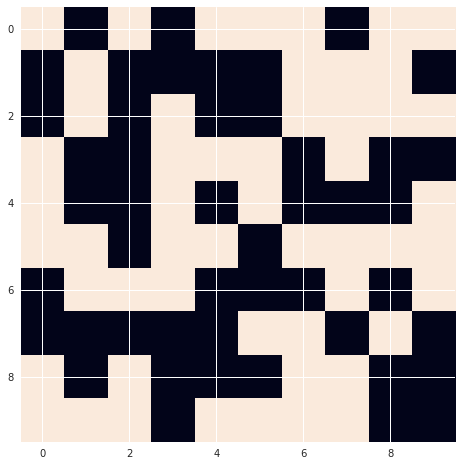

KeyboardInterrupt: 

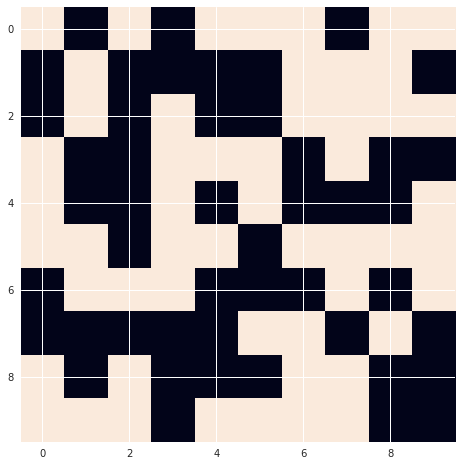

In [40]:
import time
from IPython import display

fig = plt.figure(figsize=(8, 8))

# burn-in
for _ in range(N * N):
    x = ising.sample(x)

while True:
    plt.imshow(x)
    for _ in range(N):
        x = ising.sample(x)
        history.append(x)
#     x = ising.sample(x)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)

In [96]:
len(history)

4400

## Training a RBM on an Ising Model

In [119]:
history = np.array([np.reshape(x, -1) for x in history])

In [120]:
X_train, X_test = train_test_split(history)

In [121]:
# parameters
USE_GPU = False

if USE_GPU:
    import cupy as np
else:
    import numpy as np

NUM_HIDDEN = 500

In [125]:
rbm = BernoulliRBM(num_visible, NUM_HIDDEN)

In [126]:
# training parameters
NUM_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.1
K = 1

# train
log.info(f"Starting training")
num_samples = X_train.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)

loglikelihood = []
loglikelihood_train = []

for epoch in range(1, NUM_EPOCHS + 1):
    # # Might be a good idea to increase the `k` as we get nearer to the end, so that our gradient estimate
    # # is more accurate
    # if epoch == NUM_EPOCHS:
    #     log.info(f"[{epoch} / {NUM_EPOCHS}] Increasing k: {K} -> {5 * K}")
    #     K = 5 * K
    # else:
    nll_train = np.mean([rbm.free_energy(v) for v in X_train])
    loglikelihood_train.append(nll_train)
    log.info(f"[{epoch} / {NUM_EPOCHS}] NLL (train): {nll_train:>20.5f}")
    
    nll = np.mean([rbm.free_energy(v) for v in X_test])
    log.info(f"[{epoch} / {NUM_EPOCHS}] NLL (test):  {nll:>20.5f}")
    loglikelihood.append(nll)

    bar = tqdm(total=num_samples)
    for start in range(0, num_samples, BATCH_SIZE):
        # ensure we don't go out-of-bounds
        end = min(start + BATCH_SIZE, num_samples)
        
        # take a gradient-step
        rbm.step(X_train[start: end], k=K, lr=LEARNING_RATE)
        
        # update progress
        bar.update(end - start)
    bar.close()

    # shuffle indices for next epoch
    np.random.shuffle(indices)

2018-06-29 20:56:16,968 INFO      rbm: Starting training
2018-06-29 20:56:17,478 INFO      rbm: [1 / 10] NLL (train):           -347.93101
2018-06-29 20:56:17,661 INFO      rbm: [1 / 10] NLL (test):            -347.93873

100%|██████████| 7500/7500 [00:03<00:00, 1907.63it/s]
2018-06-29 20:56:22,101 INFO      rbm: [2 / 10] NLL (train):           -227.63752
2018-06-29 20:56:22,283 INFO      rbm: [2 / 10] NLL (test):            -227.45993
100%|██████████| 7500/7500 [00:04<00:00, 1917.42it/s]
2018-06-29 20:56:26,787 INFO      rbm: [3 / 10] NLL (train):           -211.73254
2018-06-29 20:56:26,970 INFO      rbm: [3 / 10] NLL (test):            -211.73117
100%|██████████| 7500/7500 [00:03<00:00, 1899.01it/s]
2018-06-29 20:56:31,404 INFO      rbm: [4 / 10] NLL (train):           -208.90553
2018-06-29 20:56:31,586 INFO      rbm: [4 / 10] NLL (test):            -208.88867
100%|██████████| 7500/7500 [00:03<00:00, 1886.97it/s]
2018-06-29 20:56:36,053 INFO      rbm: [5 / 10] NLL (train):          

In [127]:
np.abs(rbm.b).max(), np.abs(rbm.c).max(), np.abs(rbm.W).max()

(0.5898125961996173, 0.4348958333333348, 0.7090990944503044)

### Generating from Ising

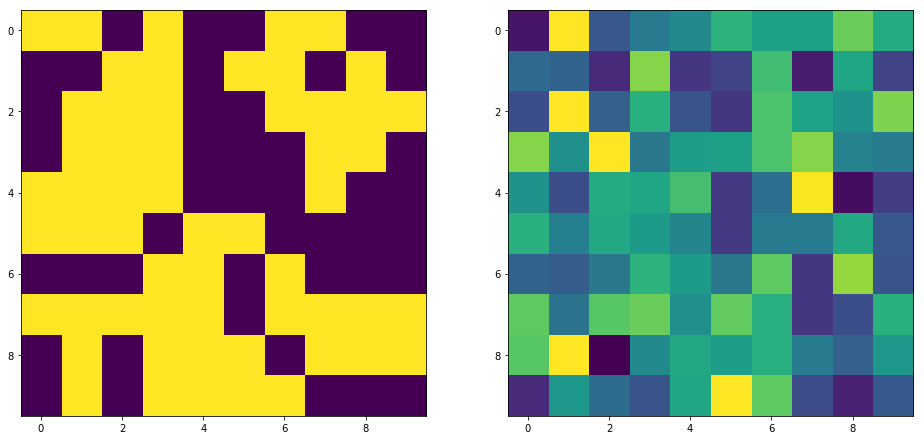

KeyboardInterrupt: 

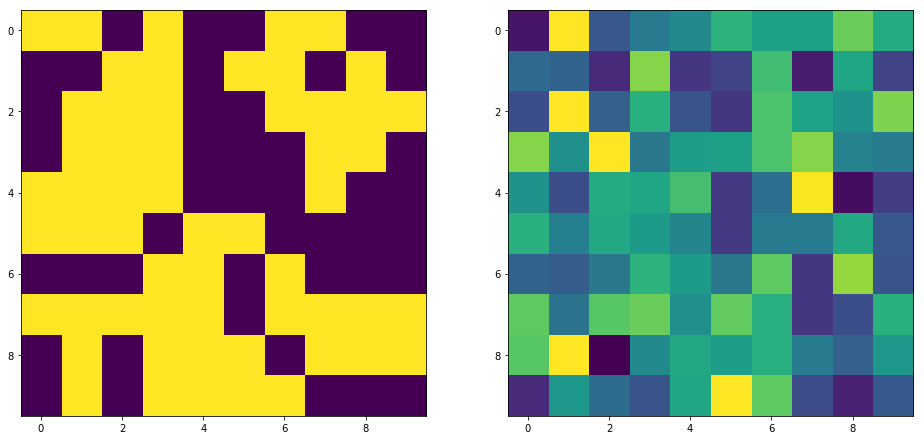

In [128]:
import time
from IPython import display

fig, axes = plt.subplots(1, 2, figsize=(16, 16))

v = X_test[np.random.randint(len(X_test))]
v_k = rbm.reconstruct(np.reshape(v, -1))

while True:
    
    axes[0].imshow(np.reshape(v, (N, N)))
    axes[1].imshow(np.reshape(v_k, (N, N)))

    v = ising.sample(np.reshape(v, (N, N)))
    
    # Reconstruct from `v` if you don't want the entire chain to be sampled
    # by the RBM, but only the next step
#     v_k = rbm.sample_visible(rbm.sample_hidden(np.reshape(v, -1)))
    v_k = rbm.reconstruct(np.reshape(v, -1))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)